# Imports

In [3]:
from collections import defaultdict
import concurrent.futures
from functools import partial, lru_cache
import pandas as pd
from openai import OpenAI
import os
import json

from transformers import RobertaTokenizer
import random
from datasets import load_dataset
import itertools
import numpy as np
from torch.utils.data import DataLoader
import re
import string
from tqdm.auto import tqdm
from sentence_transformers import SentenceTransformer, evaluation, losses, InputExample

import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

random.seed(42)

# Grab Data

In [32]:
pre_merged_anime = pd.read_csv('../data/pre_merged_anime.csv').dropna()
print(pre_merged_anime.shape)
pre_merged_anime.head()

(16206, 19)


,MAL_ID,Name,Score,Genres,English name,Type,Episodes,Premiered,Producers,Studios,Source,Duration,Rating,Ranked,Members,Favorites,Completed,On-Hold,synopsis
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,TV,26,Spring 1998,Bandai Visual,Sunrise,Original,24 min. per ep.,R - 17+ (violence & profanity),28.0,1251960,61971,718161,71513,"In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,Movie,1,Unknown,"Sunrise, Bandai Visual",Bones,Original,1 hr. 55 min.,R - 17+ (violence & profanity),159.0,273145,1174,208333,1935,"other day, another bounty—such is the life of ..."
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,TV,26,Spring 1998,Victor Entertainment,Madhouse,Manga,24 min. per ep.,PG-13 - Teens 13 or older,266.0,558913,12944,343492,25465,"Vash the Stampede is the man with a $$60,000,0..."
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,TV,26,Summer 2002,"TV Tokyo, Bandai Visual, Dentsu, Victor Entert...",Sunrise,Original,25 min. per ep.,PG-13 - Teens 13 or older,2481.0,94683,587,46165,5121,ches are individuals with special powers like ...
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,TV,52,Fall 2004,"TV Tokyo, Dentsu",Toei Animation,Manga,23 min. per ep.,PG - Children,3710.0,13224,18,7314,766,It is the dark century and the people are suff...


In [6]:
def clean_text(text):
    # Remove non-printable characters
    text = ''.join(filter(lambda x: x in string.printable, text))

    # Replace multiple whitespace characters with a single space
    text = re.sub(r'\s{2,}', ' ', text).strip()

    return text.strip()


def get_anime_description(anime_row):
    """
    Generates a custom description for an anime title based on various features from the input data.

    :param anime_row: A row from the MyAnimeList dataset containing relevant anime information.
    :return: A formatted string containing a custom description of the anime.
    """

    # Determine the type of anime (TV show or other)
    anime_type = "TV Show" if anime_row["Type"] == "TV" else anime_row["Type"]

    # Create a formatted description using the relevant features from the input data
    description = (
        f"{anime_row['Name']} is a {anime_type}.\n"
        f"Synopsis: {anime_row['synopsis']}\n"
        f"It was produced by {anime_row['Producers']} and it is from {anime_row['Studios']} Studio.\n"
        f"Its source is {anime_row['Source']}.\n"
        f"It premiered in {anime_row['Premiered']}.\n"
        f"Its genres are {anime_row['Genres']}\n"
    )

    return clean_text(description)


In [7]:
print(clean_text(get_anime_description(pre_merged_anime.iloc[0])))

Cowboy Bebop is a TV Show.
Synopsis: In the year 2071, humanity has colonized several of the planets and moons of the solar system leaving the now uninhabitable surface of planet Earth behind. The Inter Solar System Police attempts to keep peace in the galaxy, aided in part by outlaw bounty hunters, referred to as "Cowboys." The ragtag team aboard the spaceship Bebop are two such individuals. Mellow and carefree Spike Spiegel is balanced by his boisterous, pragmatic partner Jet Black as the pair makes a living chasing bounties and collecting rewards. Thrown off course by the addition of new members that they meet in their travelsEin, a genetically engineered, highly intelligent Welsh Corgi; femme fatale Faye Valentine, an enigmatic trickster with memory loss; and the strange computer whiz kid Edward Wongthe crew embarks on thrilling adventures that unravel each member's dark and mysterious past little by little. Well-balanced with high density action and light-hearted comedy, Cowboy Be

In [8]:
pre_merged_anime['generated_description'] = pre_merged_anime.apply(get_anime_description, axis=1)

In [9]:
dataset = load_dataset("profoz/anime_rating_complete")
rating_complete = dataset['train'].to_pandas().dropna()

print(rating_complete.shape)

# Creating a map to score user ratings.
# 10 and 9 are considered positive (1), 8 and 7 are neutral (0), and all others are considered negative (-1)
score_map = {
    10: 1, 
    9:  1, 
    
    8:  0, 
    7:  0, 
    
    6:  -1, 
    5:  -1, 
    4:  -1, 
    3:  -1, 
    2:  -1, 
    1:  -1, 
    0:  -1
}

rating_complete['nps_score'] = rating_complete['rating'].map(score_map)

# removing ratings with an NPS of 0 to get most polarizing opinions
# An argument can be made to keep these in, I chose not to. If you don't like that, no worries :)
rating_complete = rating_complete[rating_complete['nps_score'] != 0]

print(rating_complete.shape)
rating_complete.head(2)

Generating train split:   0%|          | 0/57633278 [00:00<?, ? examples/s]

(57633278, 3)
(29665573, 4)


,user_id,anime_id,rating,nps_score
0,0,430,9,1
1,0,1004,5,-1


In [10]:
# remove all rows with animes with under median_reviews reviews
threshold_reviews = rating_complete.groupby('anime_id').count()['rating'].quantile(.90)
print(threshold_reviews)
animes_with_enough_reviews = rating_complete.groupby('anime_id').count()['rating'] >= threshold_reviews

rating_complete = rating_complete[rating_complete['anime_id'].isin(animes_with_enough_reviews[animes_with_enough_reviews].index)]

print(rating_complete.shape)
rating_complete.head(2)

4110.0
(22183562, 4)


,user_id,anime_id,rating,nps_score
0,0,430,9,1
1,0,1004,5,-1


In [11]:
rating_complete_train, rating_complete_test = \
              np.split(rating_complete.sample(frac=1, random_state=42),
                       [int(.9*len(rating_complete))])

In [12]:
rating_complete_train.head()

,user_id,anime_id,rating,nps_score
1077792,6894,2251,9,1
31931743,196193,22789,9,1
31005293,190471,1015,9,1
49436353,303017,2476,6,-1
37205674,228438,20583,9,1


In [13]:
print(rating_complete_train.shape)
print(rating_complete_test.shape)

(19965205, 4)
(2218357, 4)


In [14]:
# Group the DataFrame by anime_id and count the number of rows corresponding to each anime
anime_counts = rating_complete_train.groupby('anime_id').count()

anime_counts['user_id'].describe()

count      1685.000000
mean      11848.786350
std       11668.782929
min        3684.000000
25%        5128.000000
50%        7741.000000
75%       13760.000000
max      110640.000000
Name: user_id, dtype: float64

In [15]:
# Group the DataFrame by anime_id and count the number of rows corresponding to each anime
user_counts = rating_complete_train.groupby('user_id').count()

user_counts['anime_id'].describe()

count    306006.000000
mean         65.244489
std          69.315504
min           1.000000
25%          19.000000
50%          45.000000
75%          87.000000
max        1409.000000
Name: anime_id, dtype: float64

# Using content embeddings to recommend titles

In [16]:
# Only use data from the training dataset rating_complete_train
anime_ids = sorted(set(pre_merged_anime['MAL_ID'].unique()) & set(rating_complete_train['anime_id'].unique()))

# Create a list of all possible anime pairs (without duplicates)
anime_pairs = list(itertools.combinations(anime_ids, 2))

# remove dupes
anime_pairs = list([tuple(sorted(pair)) for pair in anime_pairs])

# Shuffle the list of anime pairs for good measure (not actually necessary because we sample in the next cell)
random.shuffle(anime_pairs)

print(len(anime_pairs))

1408681


In [ ]:
SAMPLE = 10_000  # only taking a sample of the pairs to scan
if SAMPLE:
    anime_pairs = random.sample(anime_pairs, SAMPLE)

In [29]:
# We consider negative pairs of animes as people disagreeing on it.
#. a high (threshold) % of people promote a1 and detract from a2 therefore don't recommend one when the other was liked by a user

# e.g.
a1, a2 = 4059, 10793

def anime_pair_scores(a1, a2, verbose=False):
    a = rating_complete_train[rating_complete_train['anime_id'].isin([a1, a2])]
    a = a[a['nps_score'] != 0]
    if verbose:
        print('number of non 0 ratings found:', a.shape[0])
    
    if a.shape[0] < 50:  # need at least 50 rows
        return None

    # only keep rows with duplicates in the user_id column
    a = a[a.duplicated(subset=['user_id'], keep=False)].sort_values('user_id')

    anime_pair_scores = a.groupby('user_id', group_keys=True)['nps_score'].apply(sorted)

    two_scores = anime_pair_scores[anime_pair_scores.isin([[-1, 1], [1, 1]])].value_counts(normalize=True)
    if verbose:
        print('score breakdown', two_scores)
    
    if len(two_scores) != 2:
        return None
    disagree_score, positively_agree_score = two_scores.sort_index().tolist()

    if positively_agree_score > disagree_score:
        if verbose:
            print(f'{a1} and {a2} are similar')
        return positively_agree_score
    else:
        if verbose:
            print(f'{a1} and {a2} are dissimilar')
        return -1 * disagree_score

anime_pair_scores(a1, a2, verbose=True)

number of non 0 ratings found: 59257
score breakdown nps_score
[1, 1]     0.699389
[-1, 1]    0.300611
Name: proportion, dtype: float64
4059 and 10793 are similar


0.6993894993894993

In [ ]:
'''
This script prepares training examples where each example consists of a pair of animes.
'''
# Initializing empty lists for storing positive and negative pairs examples
positive_pairs_examples, negative_pairs_examples = [], []
considered_pairs = {}
all_scores = []

unique_mal_ids = set(pre_merged_anime['MAL_ID'].unique())

# Setting the seed value for random function to ensure the reproducibility of results
random.seed(42)

# Looping over each pair of animes
for a1, a2 in tqdm(anime_pairs):
    # If any of the animes in the pair is not found in the pre_merged_anime dataframe index, we skip the current iteration
    if a1 not in unique_mal_ids or a2 not in unique_mal_ids:
        continue

    # Calculating similarity between the sets of users who like anime a1 and anime a2
    j = anime_pair_scores(a1, a2)
    all_scores.append(j)
    text_pair = pre_merged_anime[pre_merged_anime['MAL_ID'].isin([a1, a2])]['generated_description'].tolist()

    # If the similarity is non-zero (i.e., there are some common users)
    if j is not None:
        # If similarity is greater than or equal to 0.7,
        # then the pair is considered as a positive example and added to the positive_pairs_examples list
        if j >= 0.7:  # this is arbitrary, Sinan used this threshold. You are free to play with different thresholds
            positive_pairs_examples.append(InputExample(texts=text_pair, label=j))

        # If similarity is less than -0.7,
        # then the pair is considered as a negative example and added to the negative_pairs_examples list
        elif j < -0.7:  # this is arbitrary, Sinan used this threshold. You are free to play with different thresholds
            negative_pairs_examples.append(InputExample(texts=text_pair, label=j))


  0%|          | 0/10000 [00:00<?, ?it/s]

(count    9999.000000
 mean        0.124397
 std         0.661339
 min        -0.979381
 25%        -0.603391
 50%         0.553191
 75%         0.680458
 max         0.997061
 dtype: float64,
 <Axes: >)

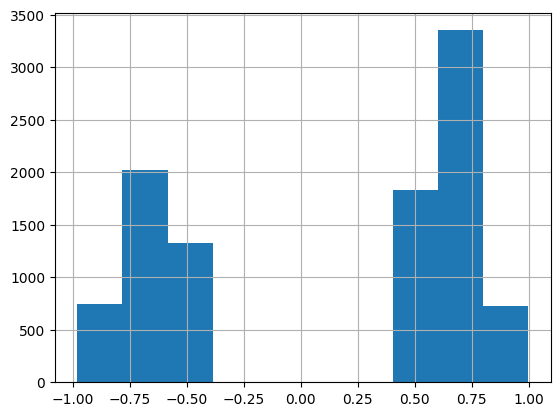

In [ ]:
# Unsurprisingly, we get a multi-modal distribution where people tend to either agree or disagree considering we removed all nps scores of 0 :)
pd.Series(all_scores).describe(), pd.Series(all_scores).hist()

In [ ]:
# This might seem like not a lot of data, but we will see sometimes that's all it takes!
len(positive_pairs_examples), len(negative_pairs_examples)

(2141, 1417)

In [ ]:
positive_pairs_examples[0].__dict__  # example of a positive pair

{'guid': '',
 'texts': ['Kuroko no Basket: Tip Off is a Special.\nSynopsis: Episode 22.5 bundled with BD/DVD volume 8. The episode covers Kuroko\'s past, when he was part of the "Generation of Miracles."\nIt was produced by Bandai Visual, Lantis and it is from Production I.G Studio.\nIts source is Manga.\nIt premiered in Unknown.\nIts genres are Sports, Comedy, School, Shounen',
  "Haikyuu!!: To the Top is a TV Show.\nSynopsis: fter their triumphant victory over Shiratorizawa Academy, the Karasuno High School volleyball team has earned their long-awaited ticket to nationals. As preparations begin, genius setter Tobio Kageyama is invited to the All-Japan Youth Training Camp to play alongside fellow nationally recognized players. Meanwhile, Kei Tsukishima is invited to a special rookie training camp for first-years within the Miyagi Prefecture. Not receiving any invitations himself, the enthusiastic Shouyou Hinata feels left behind. However, Hinata does not back down. Transforming his fr

In [ ]:
negative_pairs_examples[0].__dict__  # example of a negative pair

{'guid': '',
 'texts': ["Diamond no Ace is a TV Show.\nSynopsis: h a stray pitch that completely missed the batter, Eijun Sawamura loses his final middle school baseball game. Frustrated by this defeat, Eijun and his teammates vow to reach the national tournament once they are in high school. But everything changes when a scout unexpectedly invites him to Tokyo's prestigious Seidou High School after seeing the potential in his unusual pitching style. Encouraged by his teammates, Eijun accepts the offer, ready to improve his skills and play at a much more competitive level of baseball. However, now surrounded by a large number of skilled players, Eijun struggles to find his place on the team. He declares that he will one day become the team's ace, but that's only if fellow first year Satoru Furuya doesn't take the title first, with his breakneck fastballs that earn him a coveted spot on the starting roster. With the addition of these talented new players to an already powerful lineup, t

In [ ]:
# Splitting them up separately to keep the split a bit stratefied.
train_positive_pairs, val_positive_pairs = train_test_split(positive_pairs_examples, test_size=0.2, random_state=42)
train_negative_pairs, val_negative_pairs = train_test_split(negative_pairs_examples, test_size=0.2, random_state=42)

# Combine positive and negative pairs
train_examples = train_positive_pairs + train_negative_pairs

# Combine positive and negative pairs for the validation set
val_examples = val_positive_pairs + val_negative_pairs

In [ ]:
# An open-source semantic similarity embedder
anime_encoder = SentenceTransformer('paraphrase-distilroberta-base-v1')
anime_encoder.max_seq_length = 384     # Change context window to 384 tokens. It is normally 128

# Create a non-fast tokenizer. NOTE I am doing this purely for compatibility when saving the models.
non_fast_tokenizer = RobertaTokenizer.from_pretrained('distilroberta-base')
anime_encoder.tokenizer = non_fast_tokenizer

anime_encoder

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: RobertaModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False})
)

Token indices sequence length is longer than the specified maximum sequence length for this model (689 > 512). Running this sequence through the model will result in indexing errors


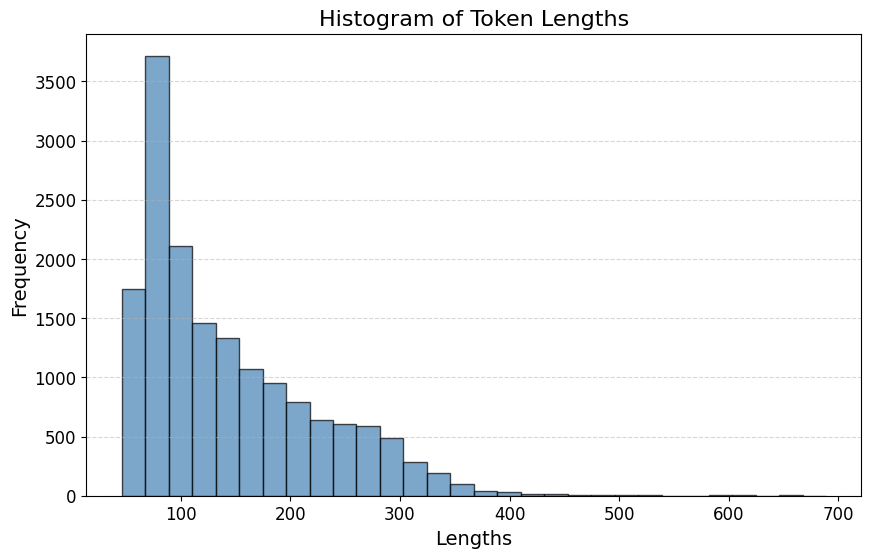

In [ ]:
lengths = []
for c in pre_merged_anime['generated_description']:
    lengths.append(anime_encoder.tokenizer(c, return_tensors='pt')['input_ids'].shape[1])

# Set up the plot and histogram
plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=30, edgecolor='black', color='steelblue', alpha=0.7)

# Customize the plot's appearance
plt.title("Histogram of Token Lengths", fontsize=16)
plt.xlabel("Lengths", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', alpha=0.5, linestyle='--')

# Display the histogram
plt.show()


In [ ]:
# Create a DataLoader for the validation examples
val_dataloader = DataLoader(
    val_examples,
    batch_size=16,
    shuffle=True
)

# Extract sentences and scores from the validation examples
val_sentences1 = [ex.texts[0] for ex in val_examples]
val_sentences2 = [ex.texts[1] for ex in val_examples]
val_scores = [ex.label for ex in val_examples]

# Create the evaluator
evaluator = evaluation.EmbeddingSimilarityEvaluator(val_sentences1, val_sentences2, val_scores)

In [ ]:
# Initial scores are not very good
anime_encoder.evaluate(evaluator)

0.14746975002767876

In [ ]:
# Create a DataLoader for the examples
train_dataloader = DataLoader(
    train_examples,
    batch_size=16,
    shuffle=True
)

# Define the loss function
loss = losses.CosineSimilarityLoss(model=anime_encoder)

# Train the model
num_epochs = 1
warmup_steps = int(len(train_dataloader) * num_epochs * 0.1)  # 10% of training data for warm-up

# Configure the training
anime_encoder.fit(
    train_objectives=[(train_dataloader, loss)],
    epochs=num_epochs,
    warmup_steps=warmup_steps,
    evaluator=evaluator,
    output_path="anime_encoder"
)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/178 [00:00<?, ?it/s]

In [ ]:
anime_encoder.evaluate(evaluator)  # better!

0.36676677694397314

In [ ]:
# Save the fine-tuned model
anime_encoder.save("anime_encoder")

# Try again with a larger open-source embedder

In [ ]:
# Load a pre-trained SBERT model
anime_encoder_bigger = SentenceTransformer('all-mpnet-base-v2')
anime_encoder_bigger

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False})
  (2): Normalize()
)

In [ ]:
# Create a DataLoader for the examples. Technically not necessary because we defined it earlier
train_dataloader = DataLoader(
    train_examples,
    batch_size=16,
    shuffle=True
)

# Define the loss function for our new model
loss = losses.CosineSimilarityLoss(model=anime_encoder_bigger)

In [ ]:
anime_encoder_bigger.evaluate(evaluator)

0.06275655231365909

In [ ]:
# Train the model
num_epochs = 1
warmup_steps = int(len(train_dataloader) * num_epochs * 0.1)  # 10% of training data for warm-up

# Configure the training
anime_encoder_bigger.fit(
    train_objectives=[(train_dataloader, loss)],
    epochs=num_epochs,
    evaluator=evaluator,
    output_path="anime_encoder_bigger"
)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/178 [00:00<?, ?it/s]

In [ ]:
anime_encoder_bigger.evaluate(evaluator)  # Got a little bit better!

0.0846954862411208

In [ ]:
anime_encoder_bigger.save('anime_encoder_bigger')

In [ ]:
embedders = (  # our embedders, one from OpenAI, one non fine-tuned, and two fine-tuned models
    'text-embedding-ada-002',
    'text-embedding-3-large',
    'paraphrase-distilroberta-base-v1',
    'anime_encoder',
    'all-mpnet-base-v2',
    'anime_encoder_bigger'
)

embeddings = {}

In [ ]:
client = OpenAI(
    api_key=os.environ.get("OPENAI_API_KEY")
)
# helper functions to get lists of embeddings from the OpenAI API
def get_embeddings(texts, engine=ENGINE):
    response = client.embeddings.create(
        input=texts,
        model=engine
    )

    return [d.embedding for d in list(response.data)]

def get_embedding(text, engine=ENGINE):
    return get_embeddings([text], engine)[0]


In [ ]:
docs = pre_merged_anime['generated_description'].tolist()
for embedder in embedders:
    if embedder in embeddings:
        continue
    if 'ada' in embedder or '3-' in embedder:
        openai_embeddings = None
        for s in tqdm(range(0, len(docs), 100)):
            if openai_embeddings is None:
                openai_embeddings = np.array(get_embeddings(docs[s:s+100], engine=embedder))
            else:
                openai_embeddings = np.vstack([openai_embeddings, np.array(get_embeddings(docs[s:s+100], engine=embedder))])
        embeddings[embedder] = openai_embeddings
    else:
        try:
            e = SentenceTransformer(embedder)
        except:
            print(f'Could not load {embedder}')
            continue
        embeddings[embedder] = e.encode(docs, batch_size=128, show_progress_bar=True)


  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

Batches:   0%|          | 0/127 [00:00<?, ?it/s]

Batches:   0%|          | 0/127 [00:00<?, ?it/s]

Batches:   0%|          | 0/127 [00:00<?, ?it/s]

Batches:   0%|          | 0/127 [00:00<?, ?it/s]

In [ ]:
'''
Given a user id

for each anime that the user gave a 9 or a 10 for:
    get k other relevant animes (semantic search given an embedder)
    for each relevant anime:
        if the anime was rating in the training set for that user, ignore
        elif the anime is not present in the testing set for that user, ignore
        else:
            check rating in testing for that user
            case rating:
                9,10 -> Promoter  ( + 1 points)
                7,8  -> Passive   ( + 0 point )
                1-6  -> Detractor ( - 1 point )
                Not in the set    (   0 points)

'''

docs = pre_merged_anime['generated_description'].tolist()
for embedder in embedders:
    if embedder in embeddings:
        continue
    if 'ada' in embedder:
        ada_embeddings = None
        for s in tqdm(range(0, len(docs), 100)):
            if ada_embeddings is None:
                ada_embeddings = np.array(get_embeddings(docs[s:s+100], engine=embedder))
            else:
                ada_embeddings = np.vstack([ada_embeddings, np.array(get_embeddings(docs[s:s+100], engine=embedder))])
        embeddings[embedder] = ada_embeddings
    else:
        try:
            e = SentenceTransformer(embedder)
        except:
            print(f'Could not load {embedder}')
            continue
        embeddings[embedder] = e.encode(docs, batch_size=128, show_progress_bar=True)


In [ ]:
embeddings.keys()  # we now have embeddings for all of the animes in our testing set for all of our embedders

dict_keys(['text-embedding-ada-002', 'text-embedding-3-large', 'paraphrase-distilroberta-base-v1', 'anime_encoder', 'all-mpnet-base-v2', 'anime_encoder_bigger'])

In [ ]:
# get cosine similarities for all pairs of animes for all embedders
cosine_sim_matrices = {embedder: cosine_similarity(embeddings[embedder]) for embedder in embedders if embedder in embeddings}

In [ ]:
@lru_cache(maxsize=None)
def get_similar_animes(anime_id: int, embedder: str, k: int = 10, verbose: bool = False) -> List[Tuple[int, float]]:
    if embedder not in embeddings:
        return []
    # Get the index of the anime in the pre_merged_anime dataframe
    try:
        idx = pre_merged_anime[pre_merged_anime['MAL_ID'] == anime_id].index[0]
    except:
        return []
    if verbose:
        print(f'idx: {idx}')
    cosine_sim_matrix = cosine_sim_matrices[embedder]

    # Get the cosine similarity scores for the given anime_id
    sim_scores = list(enumerate(cosine_sim_matrix[idx]))

    # Sort the animes based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the indices and scores of the k most similar animes
    k_indices_scores = sim_scores[1:k+1]

    # Separate indices and scores
    k_indices = [i[0] for i in k_indices_scores]
    k_scores = [round(i[1], 3) for i in k_indices_scores]

    # Get the MAL_IDs of the k most similar animes
    k_anime_ids = pre_merged_anime['MAL_ID'].iloc[k_indices].tolist()

    # Return the MAL_IDs and their corresponding similarity scores
    return list(zip(k_anime_ids, k_scores))


In [ ]:
anime_id = 4059
print(f'Anime ID: {anime_id}')
print(pre_merged_anime[pre_merged_anime['MAL_ID'] == anime_id]['generated_description'].iloc[0])
for e in embedders:
    if e in embeddings:
        similar_animes = get_similar_animes(anime_id, e, k=3, verbose=True)
        print(e)
        print(similar_animes)
        print()


Anime ID: 4059
Clannad: Mou Hitotsu no Sekai, Tomoyo-hen is a Special.
Synopsis: Clannad: Mou Hitotsu no Sekai, Tomoyo-hen is set in an alternate reality where Tomoya Okazaki dates his junior, Tomoyo Sakagami. Tomoyo has been elected to be the school's next Student Council President. This is great news as she can now work toward her goal of preventing the school's cherry blossom trees from being axed. Although Tomoya is ecstatic for her, given his reputation as a delinquent in school, his relationship with Tomoyo is making them the subject of gossip around the campus, which can potentially compromise her standing as Student Council President. The school community's disapproval of their relationship becomes more apparent when the Student Council's Vice-President and even the school's administration warn Tomoya to distance himself from Tomoyo. With the bad atmosphere widening the rift between Tomoya and Tomoyo, will Tomoya succumb to societal pressure and do as they say, or will their lo

In [ ]:
pre_merged_anime[pre_merged_anime['MAL_ID'] == 6351]['generated_description'].iloc[0]

"Clannad: After Story - Mou Hitotsu no Sekai, Kyou-hen is a Special.\nSynopsis: Included in the 8th and final DVD of Clannad ~After Story~ is an extra episode set in an alternate universe. Here, Fujibayashi Kyou is the main heroine in place of Furukawa Nagisa. Love can be wonderfully exciting, but also extremely painful. Fujibayashi Ryou, Kyou's sister, is in love with Okazaki Tomoya, the male protagonist. With the help of Kyou, Ryou manages to sum up the courage to ask him out and now Tomoya and Ryou are a couple. However, as things progress, Kyou begins to acknowledge her feelings for Tomoya, and a love-triangle is formed. As everything is revealed, the sisters learn the pains of love and try to decide between the two loves of their life: Tomoya, or each other.\nIt was produced by Animation Do and it is from Kyoto Animation Studio.\nIts source is Visual novel.\nIt premiered in Unknown.\nIts genres are Drama, Romance, School"

In [ ]:
def get_promoted_animes_from_user(user_id):
    return rating_complete_train[(rating_complete_train['user_id'] == user_id) & (rating_complete_train['nps_score'] == 1)]['anime_id'].unique().tolist()


In [ ]:
user_anime_test_ratings = defaultdict(dict)
for index, user_id, anime_id, rating, nps_score in tqdm(rating_complete_test.to_records()):
    user_anime_test_ratings[int(user_id)][int(anime_id)] = rating

  0%|          | 0/2218357 [00:00<?, ?it/s]

In [ ]:
@lru_cache()
def get_relevant_animes(reference_promoted_anime_id, embedder, k=5, verbose=True):
    preds = []
    similar_animes = get_similar_animes(reference_promoted_anime_id, embedder, k=k)

    for similar_anime_id, cosine_score in similar_animes:
        if cosine_score >= 1:
            continue  # ignoring exact matches
        if verbose:
            print(f'Recommending (ID {similar_anime_id}) Cos_Sim {cosine_score:.3f}')
        preds.append((similar_anime_id, cosine_score))
    return preds


In [ ]:
get_relevant_animes(4059, 'anime_encoder_bigger')

Recommending (ID 6351) Cos_Sim 0.808
Recommending (ID 1723) Cos_Sim 0.743
Recommending (ID 2167) Cos_Sim 0.730
Recommending (ID 4181) Cos_Sim 0.587
Recommending (ID 24417) Cos_Sim 0.495


[(6351, 0.808), (1723, 0.743), (2167, 0.73), (4181, 0.587), (24417, 0.495)]

In [ ]:
user_preds = {}

In [ ]:
def process_user(user_id, embedders, K, verbose=False):
    user_predictions = {e: defaultdict(list) for e in embedders}
    promoted_animes = set(get_promoted_animes_from_user(user_id))
    if verbose:
        print(f'{len(promoted_animes)} promoted animes')
    for promoted_anime_id in promoted_animes:
        for embedder in embedders:
            relevant_animes = get_relevant_animes(promoted_anime_id, embedder, verbose=False, k=K)
            for anime_id, cosine_score in relevant_animes:
                # if anime_id not in user_predictions[embedder] or cosine_score > user_predictions[embedder][anime_id]:
                user_predictions[embedder][anime_id].append(cosine_score)
    user_predictions = {k: sorted(v.items(), key=lambda x: len(x[1]), reverse=True)[:K] for k, v in user_predictions.items()}
    return user_id, user_predictions

# Prepare the data
user_ids = rating_complete_test['user_id'].unique()

# Set the number of workers and the value for K
num_workers = min(8, len(user_ids) + 1)
K = 3


In [ ]:
get_relevant_animes(9253, 'text-embedding-ada-002')

Recommending (ID 30484) Cos_Sim 0.936
Recommending (ID 10863) Cos_Sim 0.887
Recommending (ID 11577) Cos_Sim 0.883
Recommending (ID 37492) Cos_Sim 0.863
Recommending (ID 32188) Cos_Sim 0.857


[(30484, 0.936),
 (10863, 0.887),
 (11577, 0.883),
 (37492, 0.863),
 (32188, 0.857)]

In [ ]:
user_id, user_predictions = process_user(user_ids[0], embedders, 3, verbose=True)
user_id, user_predictions

44 promoted animes


(212268,
 {'text-embedding-ada-002': [(9253, [0.936, 0.883, 0.857, 0.887]),
   (30484, [0.936, 0.903, 0.884, 0.907]),
   (19163, [0.904, 0.917, 0.964, 0.911])],
  'text-embedding-3-large': [(30484, [0.766, 0.682, 0.672, 0.625]),
   (19163, [0.743, 0.702, 0.879, 0.687]),
   (15583, [0.713, 0.731, 0.879, 0.701])],
  'paraphrase-distilroberta-base-v1': [(30484, [0.666, 0.659, 0.558]),
   (3806, [0.647, 0.561]),
   (20939, [0.824, 0.794])],
  'anime_encoder': [(30484, [0.686, 0.603, 0.478]),
   (10495, [0.537, 0.458, 0.55]),
   (20047, [0.568, 0.519])],
  'all-mpnet-base-v2': [(36633, [0.746, 0.689, 0.909, 0.867, 0.678]),
   (10863, [0.746, 0.692, 0.795, 0.57]),
   (11577, [0.731, 0.685, 0.582, 0.795])],
  'anime_encoder_bigger': [(36633, [0.738, 0.616, 0.89, 0.839, 0.653]),
   (10863, [0.716, 0.688, 0.706, 0.553]),
   (11577, [0.691, 0.634, 0.549, 0.706])]})

In [ ]:
user_id, user_predictions = process_user(user_ids[0], embedders, 100, verbose=True)
user_id, user_predictions

44 promoted animes


(212268,
 {'text-embedding-ada-002': [(5079,
    [0.857,
     0.839,
     0.842,
     0.851,
     0.862,
     0.85,
     0.842,
     0.838,
     0.863,
     0.876,
     0.853,
     0.859,
     0.867]),
   (28677,
    [0.863,
     0.859,
     0.839,
     0.864,
     0.853,
     0.881,
     0.847,
     0.862,
     0.868,
     0.838,
     0.875,
     0.864]),
   (147,
    [0.853,
     0.852,
     0.856,
     0.834,
     0.852,
     0.851,
     0.86,
     0.839,
     0.83,
     0.866,
     0.865,
     0.87]),
   (38483,
    [0.845,
     0.864,
     0.849,
     0.839,
     0.863,
     0.851,
     0.879,
     0.865,
     0.852,
     0.836,
     0.869,
     0.86]),
   (38329,
    [0.844,
     0.854,
     0.851,
     0.945,
     0.844,
     0.847,
     0.84,
     0.864,
     0.866,
     0.874,
     0.849,
     0.841]),
   (37993,
    [0.849,
     0.851,
     0.856,
     0.853,
     0.872,
     0.844,
     0.86,
     0.84,
     0.875,
     0.869,
     0.855]),
   (38619,
    [0.858,
     0.862,

In [ ]:
user_predictions['text-embedding-ada-002']

[(9253, [0.936, 0.883, 0.857, 0.887]),
 (30484, [0.936, 0.903, 0.884, 0.907]),
 (19163, [0.904, 0.917, 0.964, 0.911])]

In [ ]:
user_preds = {}
for user_id in tqdm(user_ids):
    user_preds[user_id] = process_user(user_id, embedders, 10, verbose=False)[1]

  0%|          | 0/95433 [00:00<?, ?it/s]

In [ ]:
len(user_preds)

174437

<ipython-input-14-4d500b305dc8>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Embedder', x='Number of Animes', data=df, palette='viridis')


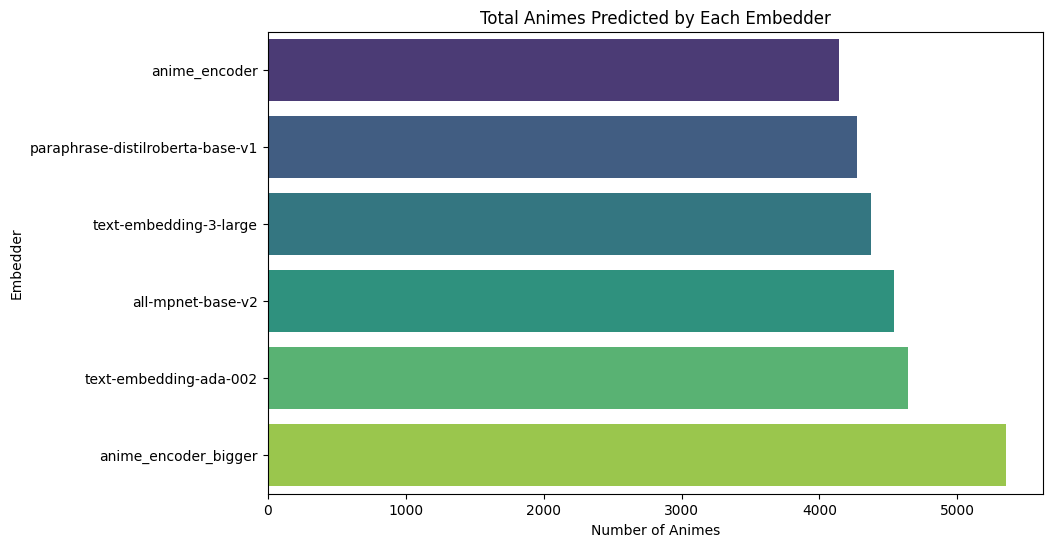

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data
data = {
    'Embedder': [
        'anime_encoder',
        'paraphrase-distilroberta-base-v1',
        'text-embedding-3-large',
        'all-mpnet-base-v2',
        'text-embedding-ada-002',
        'anime_encoder_bigger'
    ],
    'Number of Animes': [4140, 4270, 4375, 4540, 4640, 5350]
}

# Create DataFrame
df = pd.DataFrame(data)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(y='Embedder', x='Number of Animes', data=df, palette='viridis')
plt.title('Total Animes Predicted by Each Embedder')
plt.xlabel('Number of Animes')
plt.ylabel('Embedder')
plt.show()

In [ ]:
rating_complete_test.head(2)

,user_id,anime_id,rating,nps_score
34576676,212268,23847,9,1
38915290,239019,14513,10,1


In [ ]:
# Initializing list for k_values and dictionary for counts of each embedder
k_values = []
embedder_counts = defaultdict(list)
raw_counts = []

def _avg_score(scores):
    int_score = int(round(sum(scores) / len(scores)))
    return score_map[int_score]

# Creating a range of integers from 1 to 10
_r = list(range(1, 11))

# Looping over the range to get the different k values (k-factor) for recommendations
for k_factor in tqdm(_r):
    # Looping over each user and their corresponding recommendations
    for user_id, user_recs in user_preds.items():
        # Looping over each embedder and the corresponding recommendations from the embedder
        for embedder, recs_from_embedder in user_recs.items():
            # Selecting the top-k recommendations for each user from each embedder
            # final_recs = sorted(recs_from_embedder, key=lambda x: x[1], reverse=True)[:k_factor]
            # print(final_recs)

            # Looping over the top-k recommendations
            for index, (recommended_anime_id, recommendation_score) in enumerate(recs_from_embedder):
                # Fetching the user rating for the recommended anime
                user_rating = user_anime_test_ratings.get(int(user_id), {}).get(int(recommended_anime_id))

                # print(f'User {user_id} has a rating of {user_rating} for anime {recommended_anime} from embedder {embedder}')

                # Checking if the user has a rating for the recommended anime
                if user_rating is not None:
                    avg_score = sum(recommendation_score) / len(recommendation_score)
                    raw_counts.append(
                        {
                            'nps_score': score_map[user_rating], 'index': index,
                            'user_id': user_id, 'anime_id': recommended_anime_id,
                            'embedder': embedder, 'rating': user_rating,
                            'count': len(recommendation_score), 'score': avg_score
                            }
                        )
                    # The score of each recommendation is adjusted by its rank and added to the embedder_counts dictionary
                    embedder_counts[embedder].append((_avg_score(recommendation_score) * (k_factor - index) / k_factor))

    # Calculating the average Net Promoter Score (NPS) for each embedder and adding it to the k_values list
    k_values.append({e: dict(k=k_factor, avg_nps=sum(l) / len(l), predictions_found_in_test_set=len(l)) for e, l in embedder_counts.items()})


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
raw_counts[:2]

[{'nps_score': 1,
  'index': 1,
  'user_id': 239019,
  'anime_id': 14513,
  'embedder': 'paraphrase-distilroberta-base-v1',
  'rating': 10,
  'count': 2,
  'score': 0.6124999821186066},
 {'nps_score': 1,
  'index': 6,
  'user_id': 157681,
  'anime_id': 10087,
  'embedder': 'text-embedding-ada-002',
  'rating': 10,
  'count': 7,
  'score': 0.8862857142857142}]

In [ ]:
raw_counts_df = pd.DataFrame(raw_counts).drop_duplicates().reset_index()

# remove recs with only a single recommendation count to inspect the stronger signals
# raw_counts_df = raw_counts_df[raw_counts_df['count'] > 1]

print(raw_counts_df.shape)
raw_counts_df.tail()

(317250, 9)


,level_0,nps_score,index,user_id,anime_id,embedder,rating,count,score
317245,317245,1,5,261107,4282,text-embedding-ada-002,10,3,0.886000
317246,317246,1,2,261107,4282,text-embedding-3-large,10,3,0.709000
317247,317247,1,3,261107,4282,all-mpnet-base-v2,10,3,0.701000
317248,317248,1,5,261107,4282,anime_encoder_bigger,10,3,0.643667
317249,317249,1,2,76921,8769,all-mpnet-base-v2,9,4,0.784000


embedder
paraphrase-distilroberta-base-v1    0.829061
anime_encoder                       0.874422
all-mpnet-base-v2                   0.883831
text-embedding-3-large              0.895893
text-embedding-ada-002              0.902171
anime_encoder_bigger                0.905438
Name: nps_score, dtype: float64


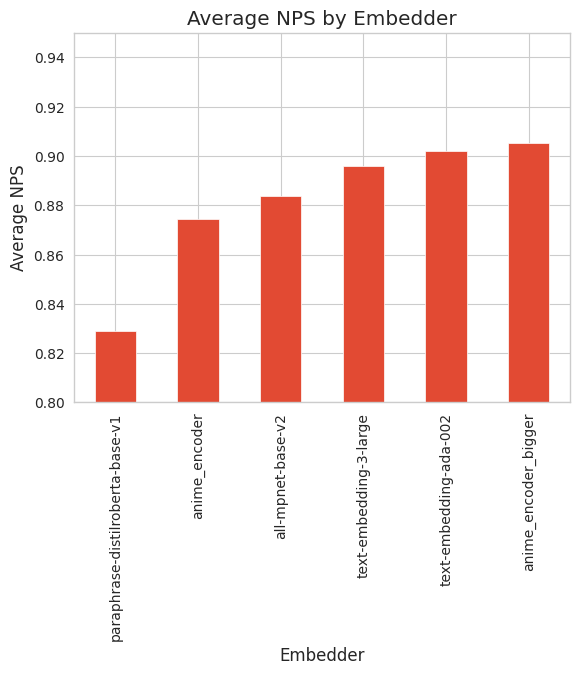

In [ ]:
# Grouping by 'embedder' and calculating mean of 'rating'
grouped_data = raw_counts_df.groupby('embedder')['nps_score'].mean().sort_values()
print(grouped_data)

# Plotting the data
grouped_data.plot(
    kind='bar',
    ylim=(.8, .95)
    )
plt.title('Average NPS by Embedder')
plt.ylabel('Average NPS')
plt.xlabel('Embedder')
plt.show()


embedder
paraphrase-distilroberta-base-v1    9.113887
anime_encoder                       9.227505
all-mpnet-base-v2                   9.270251
text-embedding-3-large              9.298831
text-embedding-ada-002              9.306445
anime_encoder_bigger                9.325051
Name: rating, dtype: float64


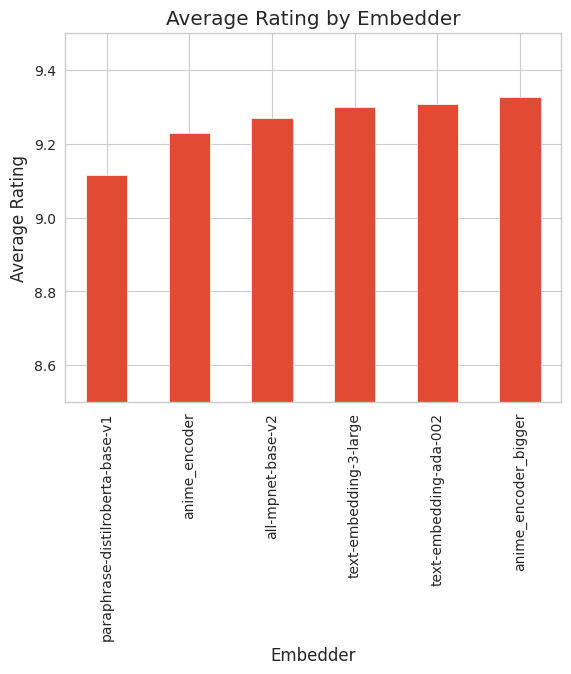

In [ ]:
# Grouping by 'embedder' and calculating mean of 'rating'
grouped_data = raw_counts_df.groupby('embedder')['rating'].mean().sort_values()
print(grouped_data)

# Plotting the data
grouped_data.plot(
    kind='bar',
    ylim=(8.5, 9.5)
    )
plt.title('Average Rating by Embedder')
plt.ylabel('Average Rating')
plt.xlabel('Embedder')
plt.show()


<Figure size 1200x600 with 0 Axes>

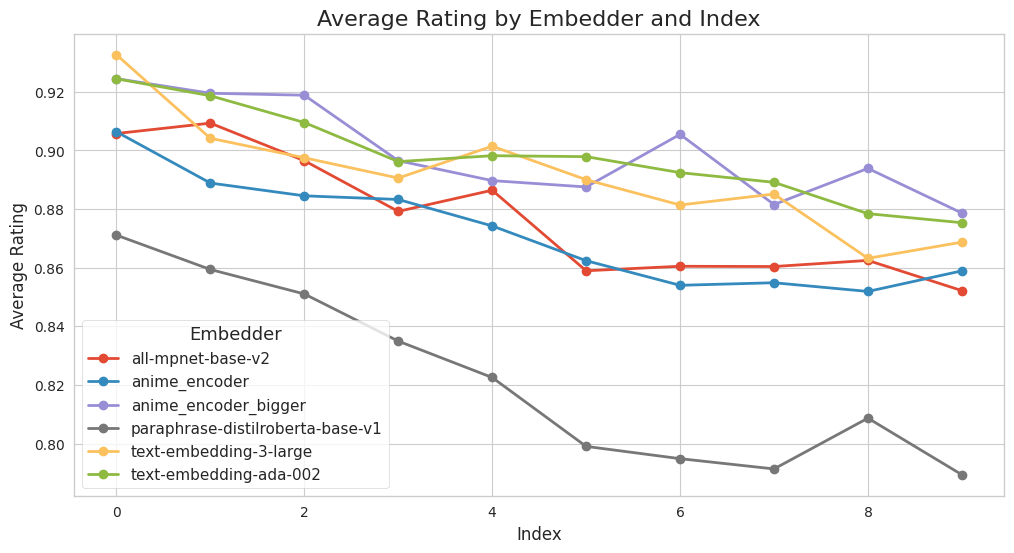

In [ ]:
# Use Seaborn style for nice looking plots
sns.set_style("whitegrid")

# Create the plot with a larger figure size for better readability
plt.figure(figsize=(12, 6))

# Group, calculate mean, and plot while specifying line width and marker style for better visibility
ax = raw_counts_df.groupby(['embedder', 'index'])['nps_score'].mean().unstack(0).plot(
    lw=2, # Line width
    marker='o', # Marker style
    figsize=(12, 6), # Figure size
    )

# Add a title to the plot
ax.set_title('Average Rating by Embedder and Index', fontsize=16)

# Label the axes for better understanding of the plot
ax.set_xlabel('Index', fontsize=12)
ax.set_ylabel('Average Rating', fontsize=12)

# Adjust the legend to not block the plot and improve readability
ax.legend(title='Embedder', title_fontsize='13', fontsize='11', loc='best')

# Show the plot
plt.show()


In [ ]:
grouped_df

embedder,all-mpnet-base-v2,anime_encoder,anime_encoder_bigger,paraphrase-distilroberta-base-v1,text-embedding-3-large,text-embedding-ada-002
index_bucket,,,,,,
0-2,0.904461,0.893734,0.921512,0.861658,0.913240,0.918296
3-6,0.872249,0.868990,0.894682,0.813835,0.891059,0.896271
7+,0.858376,0.855186,0.884615,0.796491,0.872501,0.880929


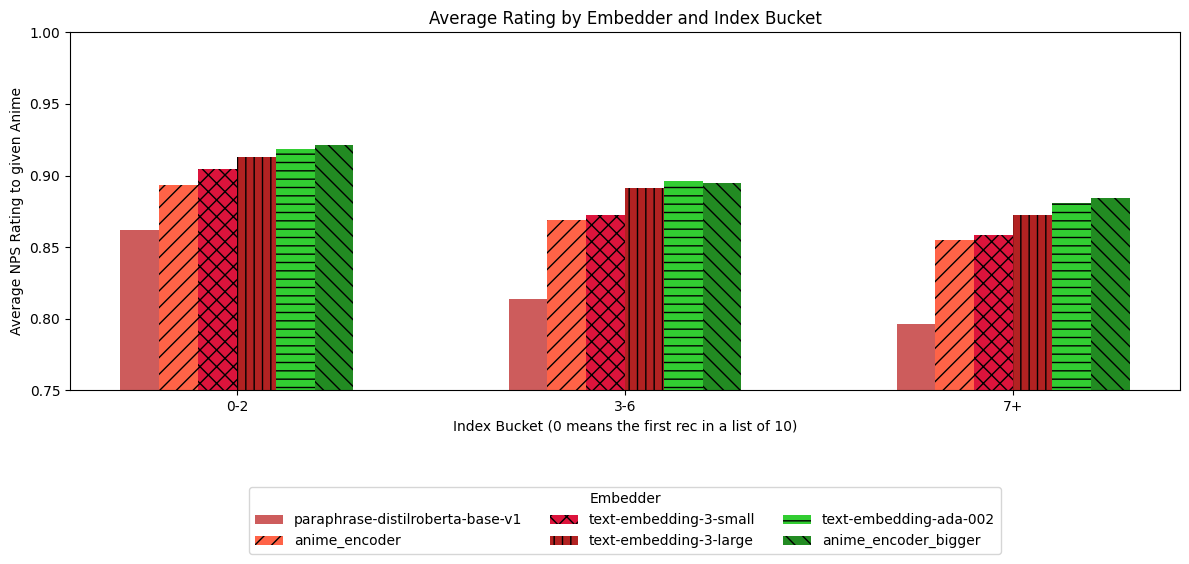

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data
data_corrected = {
    "index_bucket": ["0-2", "3-6", "7+"],
    "paraphrase-distilroberta-base-v1": [0.861658, 0.813835, 0.796491],
    "anime_encoder": [0.893734, 0.868990, 0.855186],
    "text-embedding-3-small": [0.904461, 0.872249, 0.858376],
    "text-embedding-3-large": [0.913240, 0.891059, 0.872501],
    "text-embedding-ada-002": [0.918296, 0.896271, 0.880929],
    "anime_encoder_bigger": [0.921512, 0.894682, 0.884615]
}

# Create DataFrame
df_corrected = pd.DataFrame(data_corrected)
df_corrected = df_corrected.set_index("index_bucket")

# Define colors and patterns
colors = [
    "#CD5C5C",  # light red for paraphrase-distilroberta-base-v1
    "#FF6347",  # Tomato red for text-embedding-3-small
    "#DC143C",  # Crimson red for text-embedding-3-large
    "#B22222",  # Firebrick red for text-embedding-ada-002
    "#32CD32",  # Lime green for anime_encoder
    "#228B22"   # Forest green for anime_encoder_bigger
]

patterns = ["", "//", "xx", "||", "--", "\\\\"]

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))  # Increase the figure size to make the graph wider

# Plot bars with patterns
bar_width = 0.1
index = np.arange(len(df_corrected.index))

for i, (column, color, pattern) in enumerate(zip(df_corrected.columns, colors, patterns)):
    bars = ax.bar(index + i * bar_width, df_corrected[column], bar_width, label=column, color=color, hatch=pattern)

# Adding labels and title
ax.set_ylabel("Average NPS Rating to given Anime")
ax.set_xlabel("Index Bucket (0 means the first rec in a list of 10)")
ax.set_title("Average Rating by Embedder and Index Bucket")
ax.set_ylim(0.75, 1.0)
ax.set_xticks(index + bar_width * 2.5)
ax.set_xticklabels(df_corrected.index)

# Adding legend at the bottom
ax.legend(title="Embedder", bbox_to_anchor=(0.5, -0.25), loc='upper center', ncol=3)

plt.tight_layout()
# plt.show()

plt.savefig('sdf.png', dpi=1000)


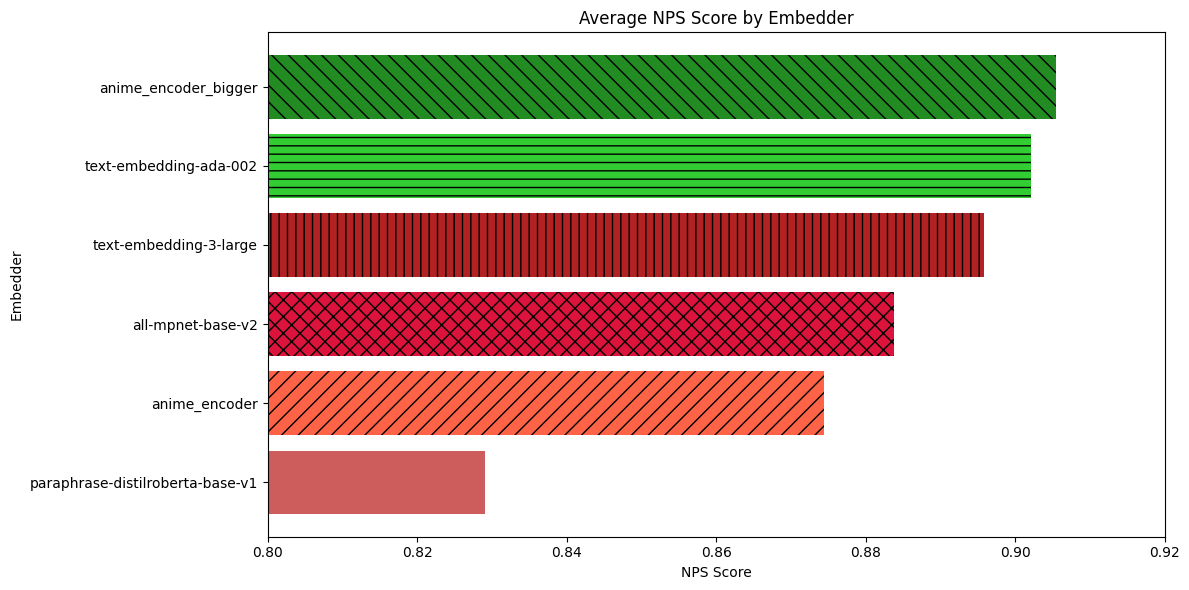

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Data
data = {
    "embedder": [
        "paraphrase-distilroberta-base-v1", 
        "anime_encoder", 
        "all-mpnet-base-v2", 
        "text-embedding-3-large", 
        "text-embedding-ada-002", 
        "anime_encoder_bigger"
    ],
    "nps_score": [
        0.829061, 
        0.874422, 
        0.883831, 
        0.895893, 
        0.902171, 
        0.905438
    ]
}

# Create DataFrame
df = pd.DataFrame(data)
df = df.set_index("embedder")

# Define colors and patterns
colors = [
    "#CD5C5C",  # light red for paraphrase-distilroberta-base-v1
    "#FF6347",  # Tomato red for text-embedding-3-small
    "#DC143C",  # Crimson red for text-embedding-3-large
    "#B22222",  # Firebrick red for text-embedding-ada-002
    "#32CD32",  # Lime green for anime_encoder
    "#228B22"   # Forest green for anime_encoder_bigger
]
patterns = ["", "//", "xx", "||", "--", "\\\\"]

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))  # Increase the figure size to make the graph wider

bars = ax.barh(df.index, df["nps_score"], color=colors)

# Add patterns to bars
for bar, pattern in zip(bars, patterns):
    bar.set_hatch(pattern)

# Adding labels and title
ax.set_xlabel("NPS Score")
ax.set_ylabel("Embedder")
ax.set_title("Average NPS Score by Embedder")
ax.set_xlim(0.8, 0.92)

# Adding legend at the bottom
plt.tight_layout()
# plt.savefig('sdf.png', dpi=1000)
plt.show()
